In [18]:
import torch
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.optim as optim
from torch import nn, optim 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from itertools import cycle
from collections import Counter
%matplotlib inline
import random
from torch.utils import data
import os
from tqdm import tqdm


In [19]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)
torch.backends.cudnn.deterministic = True

In [20]:
data_x=pd.read_csv("data_x_new.csv")
data_t=pd.read_csv("data_t_new.csv")
data_xx=pd.read_csv("data_x_x.csv")

In [21]:
h10_x=data_x.iloc[:, [0]]#初值x,t
h10_t=data_x.iloc[:, [1]]
h10_R=data_x.iloc[:,[2]]#初值h实部
h10_C=data_x.iloc[:,[3]]#初值h虚部
hb_x1=data_t.iloc[:,[1]]#边值-5，t
hb_t1=data_t.iloc[:,[0]]
hb_x2=data_t.iloc[:,[2]]#边值5，t
hb_t2=data_t.iloc[:,[0]]

h20_x=data_x.iloc[:, [0]]#初值x,t
h20_t=data_x.iloc[:, [1]]
h20_R=data_x.iloc[:,[4]]#初值h实部
h20_C=data_x.iloc[:,[5]]#初值h虚部

h30_x=data_xx.iloc[:, [0]]
h30_t=data_xx.iloc[:, [1]]
h30_r1=data_xx.iloc[:, [2]]
h30_c1=data_xx.iloc[:, [3]]
h30_r2=data_xx.iloc[:, [4]]
h30_c2=data_xx.iloc[:, [5]]

In [22]:
x = data_x['x']
t = data_t['t']

In [23]:
X, T = np.meshgrid(x,t)

In [24]:
hf= np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

In [25]:
hf_x=hf[:,[0]]
hf_t=hf[:,[1]]

In [26]:
train10_x,test10_x,train10_t,test10_t,train10_r,test10_r,train10_c,test10_c,trainb_x1,testb_x1,trainb_t1,testb_t1,trainb_x2,testb_x2,trainb_t2,testb_t2,train20_r,test20_r,train20_c,test20_c = train_test_split(h10_x,h10_t,h10_R,h10_C,hb_x1,hb_t1,hb_x2,hb_t2,h20_R,h20_C,test_size=0.2)

train30_x,test30_x,train30_t,test30_t,train30_r1,test30_r1,train30_c1,test30_c1,train30_r2,test30_r2,train30_c2,test30_c2=train_test_split(h30_x,h30_t,h30_r1,h30_c1,h30_r2,h30_c2)


In [27]:
trainu_x, testu_x, trainu_t, testu_t = train_test_split(hf_x, hf_t, test_size=0.2)



In [28]:
train10_x=torch.from_numpy(train10_x.to_numpy()).float()
train10_t=torch.from_numpy(train10_t.to_numpy()).float()

train10_r=torch.from_numpy(train10_r.to_numpy()).float()
train10_c=torch.from_numpy(train10_c.to_numpy()).float()

trainb_x1=torch.from_numpy(trainb_x1.to_numpy()).float()
trainb_t1=torch.from_numpy(trainb_t1.to_numpy()).float()
trainb_x2=torch.from_numpy(trainb_x2.to_numpy()).float()
trainb_t2=torch.from_numpy(trainb_t2.to_numpy()).float()

# train20_x=torch.from_numpy(train20_x.to_numpy()).float()
# train20_t=torch.from_numpy(train20_t.to_numpy()).float()
train20_r=torch.from_numpy(train20_r.to_numpy()).float()
train20_c=torch.from_numpy(train20_c.to_numpy()).float()


train30_x=torch.from_numpy(train30_x.to_numpy()).float()
train30_t=torch.from_numpy(train30_t.to_numpy()).float()
train30_r1=torch.from_numpy(train30_r1.to_numpy()).float()
train30_c1=torch.from_numpy(train30_c1.to_numpy()).float()
train30_r2=torch.from_numpy(train30_r2.to_numpy()).float()
train30_c2=torch.from_numpy(train30_c2.to_numpy()).float()

trainu_x=torch.from_numpy(trainu_x).float()
trainu_t=torch.from_numpy(trainu_t).float()

In [29]:
test10_x=torch.from_numpy(test10_x.to_numpy()).float()
test10_t=torch.from_numpy(test10_t.to_numpy()).float()
test10_r=torch.from_numpy(test10_r.to_numpy()).float()
test10_c=torch.from_numpy(test10_c.to_numpy()).float()

testb_x1=torch.from_numpy(testb_x1.to_numpy()).float()
testb_t1=torch.from_numpy(testb_t1.to_numpy()).float()
testb_x2=torch.from_numpy(testb_x2.to_numpy()).float()
testb_t2=torch.from_numpy(testb_t2.to_numpy()).float()

# test20_x=torch.from_numpy(test20_x.to_numpy()).float()
# test20_t=torch.from_numpy(test20_t.to_numpy()).float()
test20_r=torch.from_numpy(test20_r.to_numpy()).float()
test20_c=torch.from_numpy(test20_c.to_numpy()).float()

testu_x=torch.from_numpy(testu_x).float()
testu_t=torch.from_numpy(testu_t).float()

In [30]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [31]:
class DNN(torch.nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 60),
            torch.nn.SiLU(),
            torch.nn.Linear(60, 4)
        )

    def forward(self, x):
        return self.net(x)

In [32]:
class PhysicsInformedNN():
    def __init__(self, u10_x, u10_t, u10_r, u10_c, ub_x1, ub_t1, ub_x2, ub_t2, u20_r, u20_c, uf_x, uf_t,u30_x,u30_t,u30_r1,u30_c1,u30_r2,u30_c2):
        self.u10_x = torch.tensor(u10_x, requires_grad=True).float().to(device)
        self.u10_t = torch.tensor(u10_t, requires_grad=True).float().to(device)
        self.u10_r = torch.tensor(u10_r, requires_grad=True).float().to(device)
        self.u10_c = torch.tensor(u10_c, requires_grad=True).float().to(device)
        
        self.ub_x1 = torch.tensor(ub_x1, requires_grad=True).float().to(device)
        self.ub_x2 = torch.tensor(ub_x2, requires_grad=True).float().to(device)
        self.ub_t1 = torch.tensor(ub_t1, requires_grad=True).float().to(device)
        self.ub_t2 = torch.tensor(ub_t2, requires_grad=True).float().to(device)
        
#         self.u20_x = u20_x.clone().detach().requires_grad_(True).float().to(device)
#         self.u20_t = torch.tensor(u20_t, requires_grad=True).float().to(device)
        self.u20_r = torch.tensor(u20_r, requires_grad=True).float().to(device)
        self.u20_c = torch.tensor(u20_c, requires_grad=True).float().to(device)
        
        self.u30_x = torch.tensor(u30_x, requires_grad=True).float().to(device)
        self.u30_t = torch.tensor(u30_t, requires_grad=True).float().to(device)
        self.u30_r1 = torch.tensor(u30_r1, requires_grad=True).float().to(device)
        self.u30_c1 = torch.tensor(u30_c1, requires_grad=True).float().to(device)
        self.u30_r2 = torch.tensor(u30_r2, requires_grad=True).float().to(device)
        self.u30_c2 = torch.tensor(u30_c2, requires_grad=True).float().to(device)
      
        
        self.uf_x = torch.tensor(uf_x,requires_grad=True).float().to(device)
        self.uf_t = torch.tensor(uf_t,requires_grad=True).float().to(device)
        
        self.lambda_1 = torch.tensor([0.8], requires_grad=True).to(device)
        self.lambda_1 = torch.nn.Parameter(self.lambda_1)
        
        self.lambda_2 = torch.tensor([2.2], requires_grad=True).to(device)
        self.lambda_2 = torch.nn.Parameter(self.lambda_2)
        
        self.dnn = DNN().to(device)
        self.optimizer = torch.optim.Adam([
            {'params':self.dnn.parameters()},
            {'params': [self.lambda_1], 'lr': 0.0004},
            {'params': [self.lambda_2], 'lr': 0.0002}
        ],lr=0.006 )
        
        self.iter = 0
    
        self.losshistory=[]
    def net_u(self, x, t):  
        u1 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,0],1)
        v1 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,1],1)
        u2 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,2],1)
        v2 = torch.unsqueeze(self.dnn(torch.cat([x, t], dim=1))[:,3],1)
        return u1, v1, u2, v2

    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        beta=1
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        lambda_3 = -1
        lambda_4 = 0
        u1, v1,u2, v2= self.net_u(x, t)
        
        u1_t = torch.autograd.grad(
            u1, t, 
            grad_outputs=torch.ones_like(u1),
            retain_graph=True,
            create_graph=True
        )[0]
        u1_x = torch.autograd.grad(
            u1, x, 
            grad_outputs=torch.ones_like(u1),
            retain_graph=True,
            create_graph=True
        )[0]
        u1_xx = torch.autograd.grad(
            u1_x, x, 
            grad_outputs=torch.ones_like(u1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v1_t = torch.autograd.grad(
            v1, t, 
            grad_outputs=torch.ones_like(v1),
            retain_graph=True,
            create_graph=True
        )[0]
        v1_x = torch.autograd.grad(
            v1, x, 
            grad_outputs=torch.ones_like(v1),
            retain_graph=True,
            create_graph=True
        )[0]
        v1_xx = torch.autograd.grad(
            v1_x, x, 
            grad_outputs=torch.ones_like(v1_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        
        u2_t = torch.autograd.grad(
            u2, t, 
            grad_outputs=torch.ones_like(u2),
            retain_graph=True,
            create_graph=True
        )[0]
        u2_x = torch.autograd.grad(
            u2, x, 
            grad_outputs=torch.ones_like(u2),
            retain_graph=True,
            create_graph=True
        )[0]
        u2_xx = torch.autograd.grad(
            u2_x, x, 
            grad_outputs=torch.ones_like(u2_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v2_t = torch.autograd.grad(
            v2, t, 
            grad_outputs=torch.ones_like(v2),
            retain_graph=True,
            create_graph=True
        )[0]
        v2_x = torch.autograd.grad(
            v2, x, 
            grad_outputs=torch.ones_like(v2),
            retain_graph=True,
            create_graph=True
        )[0]
        v2_xx = torch.autograd.grad(
            v2_x, x, 
            grad_outputs=torch.ones_like(v2_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f_u1 = (
            v1_t + u1_xx
        + lambda_1*u1*(u1**2 + v1**2) + lambda_2*u1*(u2**2 + v2**2) + lambda_3*(u1*(u2**2 - v2**2) + 2*u2*v1*v2) + lambda_4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

        f_v1 = (
                -u1_t + v1_xx
            + lambda_1*v1*(u1**2 + v1**2) + lambda_2*v1*(u2**2 + v2**2) - lambda_3*(v1*(u2**2 - v2**2) - 2*u1*u2*v2) - lambda_4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
        )

        f_u2 = (
                v2_t + beta*u2_xx
            + lambda_1*u2*(u2**2 + v2**2) + lambda_2*u2*(u1**2 + v1**2) + lambda_3*(u2*(u1**2 - v1**2) + 2*u1*v2*v1) + lambda_4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
        )

        f_v2 = (
                -u2_t + beta*v2_xx
            + lambda_1*v2*(u2**2 + v2**2) + lambda_2*v2*(u1**2 + v1**2) - lambda_3*(v2*(u1**2 - v1**2) - 2*u2*u1*v1) - lambda_4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
        )
        a=u1_x
        b=v1_x
        c=u2_x
        d=v2_x
        return f_u1, f_v1, f_u2, f_v2, a, b, c, d
     
    def loss_func(self):
        for self.iter in tqdm(range(50000)):
            torch.cuda.empty_cache()
            self.optimizer.zero_grad()

            u10_pred, v10_pred, u20_pred, v20_pred = self.net_u(self.u10_x,self.u10_t)
            u30_pred1, v30_pred1, u30_pred2, v30_pred2 = self.net_u(self.u30_x,self.u30_t)
            u1b_pred1, v1b_pred1, u2b_pred1, v2b_pred1 = self.net_u(self.ub_x1,self.ub_t1)
            u1b_pred2, v1b_pred2, u2b_pred2, v2b_pred2 = self .net_u(self.ub_x2,self.ub_t2)
            
            
            a1,b1,c1,d1,u1bx_pred1, v1bx_pred1,u2bx_pred1, v2bx_pred1 = self.net_f(self.ub_x1,self.ub_t1)
            a2,b2,c2,d2,u1bx_pred2, v1bx_pred2,u2bx_pred2, v2bx_pred2 = self.net_f(self.ub_x2,self.ub_t2)
            
            f_predu1, f_predv1, f_predu2, f_predv2,a1,b1,c1,d1 = self.net_f(self.uf_x,self.uf_t)
            
            loss_u0 = torch.mean((self.u10_r - u10_pred) ** 2)+torch.mean((self.u10_c - v10_pred) ** 2)+torch.mean((self.u20_r - u20_pred) ** 2)+torch.mean((self.u20_c - v20_pred) ** 2)
            loss_ub = torch.mean((u1b_pred1 - u1b_pred2) ** 2)+torch.mean((v1b_pred1 - v1b_pred2) ** 2)+torch.mean((u2b_pred1 - u2b_pred2) ** 2)+torch.mean((v2b_pred1 - v2b_pred2) ** 2)
            loss_ubx = torch.mean((u1bx_pred1 - u1bx_pred2) ** 2)+torch.mean((v1bx_pred1 - v1bx_pred2) ** 2)+torch.mean((u2bx_pred1 - u2bx_pred2) ** 2)+torch.mean((v2bx_pred1 - v2bx_pred2) ** 2)
            loss_f = torch.mean(f_predu1 ** 2)+torch.mean(f_predv1 ** 2)+torch.mean(f_predu2 ** 2)+torch.mean(f_predv2 ** 2)
            loss_u1=torch.mean((self.u30_r1 - u30_pred1) ** 2)+torch.mean((self.u30_c1 - v30_pred1) ** 2)+torch.mean((self.u30_r2 - u30_pred2) ** 2)+torch.mean((self.u30_c2 - v30_pred2) ** 2)
            
            loss = loss_f+loss_u0 + loss_ub + loss_ubx+loss_u1
            
            loss.backward()
            self.optimizer.step()
            
            self.losshistory.append(loss.clone().detach().cpu())
            
            self.iter += 1
            with torch.no_grad():
                if self.iter % 500 == 0:
                    print('Iter %d, Loss: %.5e, Loss_u0: %.5e, Loss_ub: %.5e, Loss_ubx: %.5e, Loss_f: %.5e, Loss_u1: %.5e, lambda1: %.5e, lambda2: %.5e' % (self.iter, loss.item(), loss_u0.item(), loss_ub.item(), loss_ubx.item(), loss_f.item(), loss_u1.item(), self.lambda_1,self.lambda_2))
        return float(loss)
        
 
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)
        
    def predict1(self, X, Y):
        x = torch.tensor(X, requires_grad=True).float().to(device)
        t = torch.tensor(Y, requires_grad=True).float().to(device)

        self.dnn.eval()
        u1, v1 , u2, v2= self.net_u(x, t)
        u1 = u1.detach().cpu().numpy()
        v1 = v1.detach().cpu().numpy()
        u2 = u2.detach().cpu().numpy()
        v2 = v2.detach().cpu().numpy()
        return u1, v1, u2, v2
    
    def predict2(self, X, Y):
        x = torch.tensor(X, requires_grad=True).float().to(device)
        t = torch.tensor(Y, requires_grad=True).float().to(device)

        self.dnn.eval()
        f1, f2, f3, f4, a, b, c, d = self.net_f(x, t)
        f1 = f1.detach().cpu().numpy()
        f2 = f2.detach().cpu().numpy()
        f3 = f3.detach().cpu().numpy()
        f4 = f4.detach().cpu().numpy()
        return  f1, f2, f3, f4, a, b, c, d

In [33]:


model = PhysicsInformedNN(train10_x, train10_t, train10_r, train10_c, 
                          trainb_x1, trainb_t1, trainb_x2, trainb_t2,
                        train20_r, train20_c, trainu_x, trainu_t,
                         train30_x,train30_t, train30_r1, train30_c1,train30_r2,train30_c2)




C:\Users\npofsi\AppData\Local\Temp\ipykernel_12224\3908834773.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_x = torch.tensor(u10_x, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_12224\3908834773.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_t = torch.tensor(u10_t, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_12224\3908834773.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u10_r = torch.tensor(u10_r, requires_grad=True).float

In [34]:
%%time
               
model.train()

  1%|          | 501/50000 [00:58<1:39:16,  8.31it/s]

Iter 500, Loss: 1.32010e-01, Loss_u0: 6.41050e-03, Loss_ub: 6.23091e-05, Loss_ubx: 3.30716e-05, Loss_f: 4.81624e-02, Loss_u1: 7.73420e-02, lambda1: 9.35743e-01, lambda2: 2.22736e+00


  2%|▏         | 1002/50000 [01:56<1:29:52,  9.09it/s]

Iter 1000, Loss: 9.15918e-02, Loss_u0: 3.70193e-03, Loss_ub: 1.46510e-05, Loss_ubx: 1.94656e-05, Loss_f: 2.49596e-02, Loss_u1: 6.28961e-02, lambda1: 9.23743e-01, lambda2: 2.21043e+00


  3%|▎         | 1501/50000 [02:53<1:34:03,  8.59it/s]

Iter 1500, Loss: 7.29891e-02, Loss_u0: 2.95640e-03, Loss_ub: 1.81081e-05, Loss_ubx: 8.73527e-06, Loss_f: 1.78983e-02, Loss_u1: 5.21076e-02, lambda1: 9.14050e-01, lambda2: 2.20181e+00


  4%|▍         | 2001/50000 [03:51<1:34:32,  8.46it/s]

Iter 2000, Loss: 6.83631e-02, Loss_u0: 1.98391e-03, Loss_ub: 1.26374e-05, Loss_ubx: 1.63759e-05, Loss_f: 1.64885e-02, Loss_u1: 4.98617e-02, lambda1: 9.09488e-01, lambda2: 2.19509e+00


  5%|▌         | 2501/50000 [04:49<1:34:40,  8.36it/s]

Iter 2500, Loss: 7.07092e-02, Loss_u0: 1.95700e-03, Loss_ub: 5.74566e-04, Loss_ubx: 1.51454e-05, Loss_f: 1.97355e-02, Loss_u1: 4.84270e-02, lambda1: 9.02632e-01, lambda2: 2.18773e+00


  6%|▌         | 3001/50000 [05:46<1:30:42,  8.64it/s]

Iter 3000, Loss: 7.18886e-02, Loss_u0: 2.22163e-03, Loss_ub: 2.73164e-05, Loss_ubx: 1.69481e-05, Loss_f: 1.76140e-02, Loss_u1: 5.20087e-02, lambda1: 9.07099e-01, lambda2: 2.18466e+00


  7%|▋         | 3501/50000 [06:44<1:31:38,  8.46it/s]

Iter 3500, Loss: 6.17812e-02, Loss_u0: 1.59812e-03, Loss_ub: 2.09392e-05, Loss_ubx: 1.26338e-05, Loss_f: 1.48063e-02, Loss_u1: 4.53432e-02, lambda1: 9.01816e-01, lambda2: 2.17998e+00


  8%|▊         | 4001/50000 [07:42<1:29:00,  8.61it/s]

Iter 4000, Loss: 9.69704e-02, Loss_u0: 4.48347e-03, Loss_ub: 2.88394e-05, Loss_ubx: 2.40186e-05, Loss_f: 2.42452e-02, Loss_u1: 6.81889e-02, lambda1: 9.23058e-01, lambda2: 2.17525e+00


  9%|▉         | 4501/50000 [08:40<1:30:45,  8.36it/s]

Iter 4500, Loss: 7.19880e-02, Loss_u0: 2.53488e-03, Loss_ub: 3.70942e-05, Loss_ubx: 1.64291e-05, Loss_f: 1.73587e-02, Loss_u1: 5.20409e-02, lambda1: 9.16835e-01, lambda2: 2.16528e+00


 10%|█         | 5001/50000 [09:37<1:26:30,  8.67it/s]

Iter 5000, Loss: 9.09645e-02, Loss_u0: 3.20342e-03, Loss_ub: 3.05551e-05, Loss_ubx: 2.71968e-05, Loss_f: 2.19887e-02, Loss_u1: 6.57147e-02, lambda1: 9.23234e-01, lambda2: 2.15979e+00


 11%|█         | 5501/50000 [10:35<1:24:08,  8.82it/s]

Iter 5500, Loss: 7.24655e-02, Loss_u0: 2.49597e-03, Loss_ub: 1.08637e-05, Loss_ubx: 1.50597e-05, Loss_f: 1.81870e-02, Loss_u1: 5.17566e-02, lambda1: 9.21291e-01, lambda2: 2.15380e+00


 12%|█▏        | 6001/50000 [11:33<1:34:03,  7.80it/s]

Iter 6000, Loss: 7.17694e-02, Loss_u0: 2.20265e-03, Loss_ub: 1.84972e-05, Loss_ubx: 8.79438e-06, Loss_f: 1.46663e-02, Loss_u1: 5.48731e-02, lambda1: 9.18450e-01, lambda2: 2.15013e+00


 13%|█▎        | 6501/50000 [12:33<1:27:38,  8.27it/s]

Iter 6500, Loss: 6.18758e-02, Loss_u0: 1.50316e-03, Loss_ub: 8.23941e-06, Loss_ubx: 6.28277e-06, Loss_f: 1.52350e-02, Loss_u1: 4.51232e-02, lambda1: 9.10450e-01, lambda2: 2.14514e+00


 14%|█▍        | 7001/50000 [13:31<1:25:58,  8.34it/s]

Iter 7000, Loss: 5.23348e-02, Loss_u0: 1.14851e-03, Loss_ub: 9.56599e-06, Loss_ubx: 8.57478e-06, Loss_f: 1.09267e-02, Loss_u1: 4.02415e-02, lambda1: 8.98518e-01, lambda2: 2.13816e+00


 15%|█▌        | 7501/50000 [14:29<1:21:13,  8.72it/s]

Iter 7500, Loss: 8.38127e-02, Loss_u0: 3.08553e-03, Loss_ub: 4.85390e-05, Loss_ubx: 1.40197e-05, Loss_f: 1.86300e-02, Loss_u1: 6.20346e-02, lambda1: 9.22222e-01, lambda2: 2.13636e+00


 16%|█▌        | 8001/50000 [15:26<1:19:03,  8.85it/s]

Iter 8000, Loss: 6.19071e-02, Loss_u0: 1.09704e-03, Loss_ub: 9.69324e-06, Loss_ubx: 1.03742e-05, Loss_f: 1.46298e-02, Loss_u1: 4.61602e-02, lambda1: 9.05029e-01, lambda2: 2.12486e+00


 17%|█▋        | 8501/50000 [16:24<1:18:53,  8.77it/s]

Iter 8500, Loss: 4.95963e-02, Loss_u0: 1.16913e-03, Loss_ub: 4.52778e-06, Loss_ubx: 8.63555e-06, Loss_f: 1.20138e-02, Loss_u1: 3.64002e-02, lambda1: 8.94015e-01, lambda2: 2.11602e+00


 18%|█▊        | 9001/50000 [17:22<1:20:32,  8.48it/s]

Iter 9000, Loss: 9.74473e-02, Loss_u0: 3.98172e-03, Loss_ub: 1.06346e-05, Loss_ubx: 1.62389e-05, Loss_f: 2.39925e-02, Loss_u1: 6.94462e-02, lambda1: 9.59579e-01, lambda2: 2.09824e+00


 19%|█▉        | 9501/50000 [18:19<1:16:26,  8.83it/s]

Iter 9500, Loss: 8.11708e-02, Loss_u0: 2.91282e-03, Loss_ub: 1.45920e-05, Loss_ubx: 1.21127e-05, Loss_f: 2.00991e-02, Loss_u1: 5.81322e-02, lambda1: 9.36776e-01, lambda2: 2.08542e+00


 20%|██        | 10001/50000 [19:17<1:16:01,  8.77it/s]

Iter 10000, Loss: 7.78497e-02, Loss_u0: 2.76477e-03, Loss_ub: 1.06996e-05, Loss_ubx: 7.72579e-06, Loss_f: 2.03581e-02, Loss_u1: 5.47083e-02, lambda1: 9.16377e-01, lambda2: 2.07558e+00


 21%|██        | 10501/50000 [20:15<1:15:50,  8.68it/s]

Iter 10500, Loss: 7.05676e-02, Loss_u0: 1.82193e-03, Loss_ub: 6.80066e-06, Loss_ubx: 6.12629e-06, Loss_f: 2.00358e-02, Loss_u1: 4.86969e-02, lambda1: 8.98796e-01, lambda2: 2.06831e+00


 22%|██▏       | 11001/50000 [21:12<1:14:14,  8.76it/s]

Iter 11000, Loss: 6.01913e-02, Loss_u0: 1.31002e-03, Loss_ub: 7.20107e-06, Loss_ubx: 5.58831e-06, Loss_f: 1.42853e-02, Loss_u1: 4.45832e-02, lambda1: 8.86219e-01, lambda2: 2.06346e+00


 23%|██▎       | 11501/50000 [22:10<1:12:52,  8.80it/s]

Iter 11500, Loss: 5.83132e-02, Loss_u0: 1.45103e-03, Loss_ub: 7.08292e-06, Loss_ubx: 5.37988e-06, Loss_f: 1.23706e-02, Loss_u1: 4.44791e-02, lambda1: 8.84315e-01, lambda2: 2.06009e+00


 24%|██▍       | 12001/50000 [23:08<1:14:50,  8.46it/s]

Iter 12000, Loss: 5.34702e-02, Loss_u0: 1.14398e-03, Loss_ub: 8.07650e-06, Loss_ubx: 4.17626e-06, Loss_f: 1.14498e-02, Loss_u1: 4.08642e-02, lambda1: 8.71998e-01, lambda2: 2.05361e+00


 25%|██▌       | 12501/50000 [24:05<1:16:40,  8.15it/s]

Iter 12500, Loss: 4.51416e-02, Loss_u0: 9.47734e-04, Loss_ub: 5.18503e-06, Loss_ubx: 3.84105e-06, Loss_f: 7.45849e-03, Loss_u1: 3.67264e-02, lambda1: 8.53103e-01, lambda2: 2.04331e+00


 26%|██▌       | 13001/50000 [25:03<1:11:58,  8.57it/s]

Iter 13000, Loss: 6.52721e-02, Loss_u0: 1.80706e-03, Loss_ub: 1.46353e-05, Loss_ubx: 6.39532e-06, Loss_f: 1.17198e-02, Loss_u1: 5.17242e-02, lambda1: 8.60509e-01, lambda2: 2.04328e+00


 27%|██▋       | 13501/50000 [26:00<1:08:03,  8.94it/s]

Iter 13500, Loss: 6.21923e-02, Loss_u0: 1.43522e-03, Loss_ub: 1.16146e-05, Loss_ubx: 7.66521e-06, Loss_f: 1.95226e-02, Loss_u1: 4.12152e-02, lambda1: 8.51943e-01, lambda2: 2.03904e+00


 28%|██▊       | 14001/50000 [26:58<1:07:49,  8.85it/s]

Iter 14000, Loss: 4.92008e-02, Loss_u0: 1.18391e-03, Loss_ub: 6.40931e-06, Loss_ubx: 5.07957e-06, Loss_f: 9.89102e-03, Loss_u1: 3.81144e-02, lambda1: 8.44154e-01, lambda2: 2.03349e+00


 29%|██▉       | 14501/50000 [27:56<1:08:58,  8.58it/s]

Iter 14500, Loss: 4.62253e-02, Loss_u0: 1.12555e-03, Loss_ub: 3.39311e-06, Loss_ubx: 3.69154e-06, Loss_f: 1.08120e-02, Loss_u1: 3.42808e-02, lambda1: 8.32411e-01, lambda2: 2.02684e+00


 30%|███       | 15001/50000 [28:54<1:08:34,  8.51it/s]

Iter 15000, Loss: 4.53657e-02, Loss_u0: 1.11930e-03, Loss_ub: 2.08125e-06, Loss_ubx: 2.22935e-06, Loss_f: 1.02169e-02, Loss_u1: 3.40253e-02, lambda1: 8.30667e-01, lambda2: 2.02455e+00


 31%|███       | 15501/50000 [29:52<1:05:05,  8.83it/s]

Iter 15500, Loss: 5.01944e-02, Loss_u0: 1.49248e-03, Loss_ub: 7.49326e-06, Loss_ubx: 5.64339e-06, Loss_f: 1.42048e-02, Loss_u1: 3.44839e-02, lambda1: 8.30673e-01, lambda2: 2.02070e+00


 32%|███▏      | 16001/50000 [30:50<1:07:29,  8.40it/s]

Iter 16000, Loss: 4.44562e-02, Loss_u0: 1.09190e-03, Loss_ub: 1.56952e-05, Loss_ubx: 1.02096e-05, Loss_f: 1.23964e-02, Loss_u1: 3.09419e-02, lambda1: 8.21492e-01, lambda2: 2.01538e+00


 33%|███▎      | 16501/50000 [31:48<1:07:09,  8.31it/s]

Iter 16500, Loss: 3.73029e-02, Loss_u0: 9.39316e-04, Loss_ub: 7.10057e-06, Loss_ubx: 7.55829e-06, Loss_f: 8.05872e-03, Loss_u1: 2.82902e-02, lambda1: 8.11544e-01, lambda2: 2.01074e+00


 34%|███▍      | 17001/50000 [32:45<1:04:46,  8.49it/s]

Iter 17000, Loss: 6.95003e-02, Loss_u0: 1.96741e-03, Loss_ub: 3.95626e-06, Loss_ubx: 2.61320e-06, Loss_f: 1.60288e-02, Loss_u1: 5.14975e-02, lambda1: 8.84388e-01, lambda2: 2.03796e+00


 35%|███▌      | 17501/50000 [33:43<1:03:56,  8.47it/s]

Iter 17500, Loss: 4.96121e-02, Loss_u0: 1.14237e-03, Loss_ub: 1.99074e-06, Loss_ubx: 1.12911e-06, Loss_f: 1.40470e-02, Loss_u1: 3.44197e-02, lambda1: 8.94944e-01, lambda2: 2.04065e+00


 36%|███▌      | 18001/50000 [34:41<59:25,  8.97it/s]  

Iter 18000, Loss: 3.78203e-02, Loss_u0: 9.47330e-04, Loss_ub: 5.23283e-07, Loss_ubx: 3.01507e-07, Loss_f: 8.08052e-03, Loss_u1: 2.87916e-02, lambda1: 8.84401e-01, lambda2: 2.03627e+00


 37%|███▋      | 18501/50000 [35:38<1:00:05,  8.74it/s]

Iter 18500, Loss: 3.26277e-02, Loss_u0: 7.38833e-04, Loss_ub: 4.89788e-07, Loss_ubx: 7.53148e-07, Loss_f: 6.04621e-03, Loss_u1: 2.58414e-02, lambda1: 8.71639e-01, lambda2: 2.02850e+00


 38%|███▊      | 19001/50000 [36:36<59:06,  8.74it/s]  

Iter 19000, Loss: 3.12812e-02, Loss_u0: 8.12673e-04, Loss_ub: 2.14504e-06, Loss_ubx: 2.09076e-06, Loss_f: 6.01087e-03, Loss_u1: 2.44534e-02, lambda1: 8.59019e-01, lambda2: 2.01923e+00


 39%|███▉      | 19501/50000 [37:33<56:45,  8.96it/s]  

Iter 19500, Loss: 1.94602e-01, Loss_u0: 5.03206e-03, Loss_ub: 8.67500e-06, Loss_ubx: 3.06604e-07, Loss_f: 3.45973e-02, Loss_u1: 1.54964e-01, lambda1: 8.89075e-01, lambda2: 2.03780e+00


 40%|████      | 20001/50000 [38:31<58:35,  8.53it/s]  

Iter 20000, Loss: 1.37085e-01, Loss_u0: 2.96292e-03, Loss_ub: 4.11193e-06, Loss_ubx: 6.30355e-07, Loss_f: 2.85288e-02, Loss_u1: 1.05588e-01, lambda1: 9.52685e-01, lambda2: 2.06385e+00


 41%|████      | 20501/50000 [39:29<57:07,  8.61it/s]  

Iter 20500, Loss: 1.08400e-01, Loss_u0: 2.68844e-03, Loss_ub: 1.49419e-06, Loss_ubx: 8.69231e-07, Loss_f: 2.38879e-02, Loss_u1: 8.18209e-02, lambda1: 1.04297e+00, lambda2: 2.09834e+00


 42%|████▏     | 21001/50000 [40:26<56:54,  8.49it/s]  

Iter 21000, Loss: 9.57531e-02, Loss_u0: 3.54210e-03, Loss_ub: 2.66230e-06, Loss_ubx: 6.40201e-07, Loss_f: 2.29751e-02, Loss_u1: 6.92326e-02, lambda1: 1.11151e+00, lambda2: 2.12329e+00


 43%|████▎     | 21501/50000 [41:24<56:37,  8.39it/s]

Iter 21500, Loss: 8.63725e-02, Loss_u0: 2.36312e-03, Loss_ub: 1.53306e-06, Loss_ubx: 3.94947e-07, Loss_f: 2.16828e-02, Loss_u1: 6.23247e-02, lambda1: 1.13950e+00, lambda2: 2.13142e+00


 44%|████▍     | 22001/50000 [42:21<53:40,  8.69it/s]

Iter 22000, Loss: 7.33811e-02, Loss_u0: 1.65507e-03, Loss_ub: 1.49955e-06, Loss_ubx: 1.23445e-07, Loss_f: 1.61037e-02, Loss_u1: 5.56207e-02, lambda1: 1.13900e+00, lambda2: 2.12902e+00


 45%|████▌     | 22501/50000 [43:19<52:09,  8.79it/s]

Iter 22500, Loss: 6.41044e-02, Loss_u0: 1.24187e-03, Loss_ub: 1.26653e-06, Loss_ubx: 4.08973e-07, Loss_f: 1.46361e-02, Loss_u1: 4.82248e-02, lambda1: 1.12486e+00, lambda2: 2.12186e+00


 46%|████▌     | 23001/50000 [44:18<54:26,  8.27it/s]

Iter 23000, Loss: 6.01137e-02, Loss_u0: 1.38074e-03, Loss_ub: 1.54230e-06, Loss_ubx: 1.00999e-06, Loss_f: 1.35728e-02, Loss_u1: 4.51576e-02, lambda1: 1.10395e+00, lambda2: 2.11113e+00


 47%|████▋     | 23501/50000 [45:16<51:45,  8.53it/s]

Iter 23500, Loss: 5.58596e-02, Loss_u0: 1.20056e-03, Loss_ub: 2.57078e-06, Loss_ubx: 3.02736e-06, Loss_f: 1.11739e-02, Loss_u1: 4.34796e-02, lambda1: 1.07800e+00, lambda2: 2.09787e+00


 48%|████▊     | 24001/50000 [46:14<53:16,  8.13it/s]

Iter 24000, Loss: 7.52744e-02, Loss_u0: 1.61463e-03, Loss_ub: 2.26277e-06, Loss_ubx: 1.72586e-06, Loss_f: 1.74973e-02, Loss_u1: 5.61585e-02, lambda1: 1.06779e+00, lambda2: 2.09373e+00


 49%|████▉     | 24501/50000 [47:12<47:09,  9.01it/s]

Iter 24500, Loss: 6.67000e-02, Loss_u0: 1.46157e-03, Loss_ub: 1.24406e-06, Loss_ubx: 1.31338e-06, Loss_f: 1.57413e-02, Loss_u1: 4.94945e-02, lambda1: 1.05784e+00, lambda2: 2.08752e+00


 50%|█████     | 25001/50000 [48:11<47:02,  8.86it/s]

Iter 25000, Loss: 6.37144e-02, Loss_u0: 1.68131e-03, Loss_ub: 9.83843e-07, Loss_ubx: 6.27987e-07, Loss_f: 1.57828e-02, Loss_u1: 4.62487e-02, lambda1: 1.04161e+00, lambda2: 2.07862e+00


 51%|█████     | 25501/50000 [49:08<46:00,  8.87it/s]

Iter 25500, Loss: 6.17344e-02, Loss_u0: 1.47222e-03, Loss_ub: 4.77996e-07, Loss_ubx: 1.88396e-07, Loss_f: 1.62193e-02, Loss_u1: 4.40422e-02, lambda1: 1.02536e+00, lambda2: 2.06987e+00


 52%|█████▏    | 26001/50000 [50:06<47:11,  8.47it/s]

Iter 26000, Loss: 6.23752e-02, Loss_u0: 3.02531e-03, Loss_ub: 4.48073e-07, Loss_ubx: 4.08947e-07, Loss_f: 1.83268e-02, Loss_u1: 4.10223e-02, lambda1: 1.00881e+00, lambda2: 2.06125e+00


 53%|█████▎    | 26501/50000 [51:05<46:33,  8.41it/s]

Iter 26500, Loss: 5.12469e-02, Loss_u0: 1.48547e-03, Loss_ub: 9.41144e-07, Loss_ubx: 4.64764e-07, Loss_f: 1.20752e-02, Loss_u1: 3.76848e-02, lambda1: 9.92077e-01, lambda2: 2.05202e+00


 54%|█████▍    | 27001/50000 [52:03<45:04,  8.51it/s]

Iter 27000, Loss: 4.71644e-02, Loss_u0: 1.29221e-03, Loss_ub: 2.31948e-06, Loss_ubx: 7.74499e-07, Loss_f: 1.02792e-02, Loss_u1: 3.55899e-02, lambda1: 9.74442e-01, lambda2: 2.04278e+00


 55%|█████▌    | 27501/50000 [53:01<42:34,  8.81it/s]

Iter 27500, Loss: 4.58280e-02, Loss_u0: 1.21187e-03, Loss_ub: 1.32348e-06, Loss_ubx: 5.69776e-07, Loss_f: 9.76426e-03, Loss_u1: 3.48500e-02, lambda1: 9.56873e-01, lambda2: 2.03319e+00


 56%|█████▌    | 28001/50000 [53:58<48:51,  7.51it/s]

Iter 28000, Loss: 4.43879e-02, Loss_u0: 1.09025e-03, Loss_ub: 4.93945e-07, Loss_ubx: 3.59416e-07, Loss_f: 9.64844e-03, Loss_u1: 3.36484e-02, lambda1: 9.40411e-01, lambda2: 2.02372e+00


 57%|█████▋    | 28501/50000 [54:56<41:02,  8.73it/s]

Iter 28500, Loss: 4.16993e-02, Loss_u0: 1.05317e-03, Loss_ub: 2.51347e-07, Loss_ubx: 1.90719e-07, Loss_f: 8.60103e-03, Loss_u1: 3.20447e-02, lambda1: 9.28315e-01, lambda2: 2.01652e+00


 58%|█████▊    | 29001/50000 [55:55<40:22,  8.67it/s]

Iter 29000, Loss: 3.96459e-02, Loss_u0: 9.02114e-04, Loss_ub: 8.38359e-07, Loss_ubx: 1.91327e-07, Loss_f: 7.73412e-03, Loss_u1: 3.10087e-02, lambda1: 9.14122e-01, lambda2: 2.00898e+00


 59%|█████▉    | 29501/50000 [56:53<41:09,  8.30it/s]

Iter 29500, Loss: 4.32389e-01, Loss_u0: 1.25415e-01, Loss_ub: 4.87044e-21, Loss_ubx: 2.56006e-19, Loss_f: 2.31965e-02, Loss_u1: 2.83777e-01, lambda1: 8.97929e-01, lambda2: 2.00013e+00


 60%|██████    | 30001/50000 [57:52<37:59,  8.77it/s]

Iter 30000, Loss: 4.21697e-01, Loss_u0: 1.17918e-01, Loss_ub: 3.84745e-18, Loss_ubx: 7.90471e-17, Loss_f: 2.27096e-02, Loss_u1: 2.81070e-01, lambda1: 8.98028e-01, lambda2: 2.00013e+00


 61%|██████    | 30501/50000 [58:50<37:30,  8.67it/s]

Iter 30500, Loss: 4.19319e-01, Loss_u0: 1.13958e-01, Loss_ub: 5.65659e-21, Loss_ubx: 1.88300e-19, Loss_f: 2.36133e-02, Loss_u1: 2.81748e-01, lambda1: 8.97213e-01, lambda2: 2.00013e+00


 62%|██████▏   | 31001/50000 [59:48<37:10,  8.52it/s]

Iter 31000, Loss: 4.15761e-01, Loss_u0: 1.14432e-01, Loss_ub: 6.61744e-25, Loss_ubx: 2.90974e-23, Loss_f: 1.94878e-02, Loss_u1: 2.81841e-01, lambda1: 8.95920e-01, lambda2: 2.00013e+00


 63%|██████▎   | 31501/50000 [1:00:46<36:03,  8.55it/s]

Iter 31500, Loss: 4.08907e-01, Loss_u0: 1.11753e-01, Loss_ub: 9.92617e-25, Loss_ubx: 6.26109e-23, Loss_f: 1.63733e-02, Loss_u1: 2.80781e-01, lambda1: 8.94456e-01, lambda2: 2.00013e+00


 64%|██████▍   | 32001/50000 [1:01:44<34:12,  8.77it/s]

Iter 32000, Loss: 5.43070e-01, Loss_u0: 2.33545e-01, Loss_ub: 0.00000e+00, Loss_ubx: 1.84009e-25, Loss_f: 2.82617e-07, Loss_u1: 3.09526e-01, lambda1: 8.93635e-01, lambda2: 2.00012e+00


 65%|██████▌   | 32501/50000 [1:02:42<33:57,  8.59it/s]

Iter 32500, Loss: 5.43065e-01, Loss_u0: 2.33555e-01, Loss_ub: 0.00000e+00, Loss_ubx: 2.55719e-25, Loss_f: 3.58795e-07, Loss_u1: 3.09509e-01, lambda1: 8.93635e-01, lambda2: 2.00012e+00


 66%|██████▌   | 33001/50000 [1:03:40<32:18,  8.77it/s]

Iter 33000, Loss: 5.43075e-01, Loss_u0: 2.33554e-01, Loss_ub: 0.00000e+00, Loss_ubx: 9.58926e-24, Loss_f: 6.04943e-08, Loss_u1: 3.09521e-01, lambda1: 8.94232e-01, lambda2: 2.00012e+00


 67%|██████▋   | 33501/50000 [1:04:38<32:32,  8.45it/s]

Iter 33500, Loss: 5.43075e-01, Loss_u0: 2.33556e-01, Loss_ub: 0.00000e+00, Loss_ubx: 9.92911e-24, Loss_f: 4.98462e-08, Loss_u1: 3.09519e-01, lambda1: 8.94232e-01, lambda2: 2.00012e+00


 68%|██████▊   | 34001/50000 [1:05:36<29:33,  9.02it/s]

Iter 34000, Loss: 5.43075e-01, Loss_u0: 2.33556e-01, Loss_ub: 0.00000e+00, Loss_ubx: 1.03834e-23, Loss_f: 4.83456e-08, Loss_u1: 3.09519e-01, lambda1: 8.94232e-01, lambda2: 2.00012e+00


 69%|██████▉   | 34501/50000 [1:06:33<30:41,  8.42it/s]

Iter 34500, Loss: 5.43075e-01, Loss_u0: 2.33556e-01, Loss_ub: 0.00000e+00, Loss_ubx: 1.10071e-23, Loss_f: 4.77890e-08, Loss_u1: 3.09519e-01, lambda1: 8.94232e-01, lambda2: 2.00012e+00


 70%|███████   | 35001/50000 [1:07:31<29:21,  8.51it/s]

Iter 35000, Loss: 5.43075e-01, Loss_u0: 2.33556e-01, Loss_ub: 0.00000e+00, Loss_ubx: 1.18880e-23, Loss_f: 4.75162e-08, Loss_u1: 3.09519e-01, lambda1: 8.94232e-01, lambda2: 2.00012e+00


 71%|███████   | 35449/50000 [1:08:24<28:26,  8.53it/s]

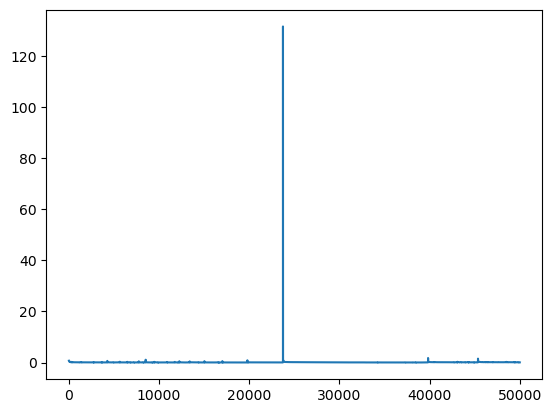

In [ ]:
plt.plot(model.losshistory)

In [ ]:
u00_1, v00_1, u00_2, v00_2 = model.predict1(test10_x,test10_t)
u11_1, v11_1, u11_2, v11_2 = model.predict1(testb_x1,testb_t1)
u22_1, v22_1, u22_2, v22_2 = model.predict1(testb_x2,testb_t2)
a1,b1,c1,d1, ux11_1, vx11_1, ux11_2, vx11_2 = model.predict2(testb_x1,testb_t1)
a1,b1,c1,d1, ux22_1, vx22_1, ux22_2, vx22_2 = model.predict2(testb_x2,testb_t2)

f1, f2, f3, f4,a1,b1,c1,d1 = model.predict2(testu_x,testu_t)     

C:\Users\npofsi\AppData\Local\Temp\ipykernel_21764\1886832149.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_21764\1886832149.py:207: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(Y, requires_grad=True).float().to(device)
C:\Users\npofsi\AppData\Local\Temp\ipykernel_21764\1886832149.py:218: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(X, requires_grad=True).float().to(device)
C:\Users\npofsi\App

In [ ]:
error_u0= ((np.linalg.norm(test10_r - u00_1, 2))**2+(np.linalg.norm(test10_c - v00_1, 2))**2+(np.linalg.norm(test20_r - u00_2, 2))**2+(np.linalg.norm(test20_c - v00_2, 2))**2)/20
error_ub= ((np.linalg.norm(u11_1 - u22_1, 2))**2+(np.linalg.norm(v11_1 - v22_1, 2))**2+(np.linalg.norm(u11_1 - u22_1, 2))**2+(np.linalg.norm(v11_1 - v22_1, 2))**2)/20
error_ubx= (
    (np.linalg.norm(ux11_1.cpu().detach().numpy() - ux22_1.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(vx11_1.cpu().detach().numpy() - vx22_1.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(ux11_2.cpu().detach().numpy() - ux22_2.cpu().detach().numpy(), 2))**2+
    (np.linalg.norm(vx11_2.cpu().detach().numpy() - vx22_2.cpu().detach().numpy(), 2))**2)/20

error_f= ((np.linalg.norm(f1, 2))**2+(np.linalg.norm(f2, 2))**2+(np.linalg.norm(f1, 2))**2+(np.linalg.norm(f2, 2))**2)/2000
print('Error_u0: %.5e, Error_ub: %.5e, Error_ubx: %.5e, Error_f: %.5e' % (error_u0.item(), error_ub.item(), error_ubx.item(), error_f.item()))




Error_u0: 3.83142e-03, Error_ub: 5.26785e-07, Error_ubx: 7.66790e-08, Error_f: 6.64155e-02
